In [52]:
%matplotlib inline
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression, BayesianRidge
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [3]:
filenames = glob.glob('Datathon*.csv')

In [4]:
pre_dat = pd.DataFrame({})
for ind, filename in enumerate(filenames):
    print(ind)
    tmp_dat = pd.read_csv(filename)
    pre_dat = pre_dat.append(tmp_dat)    
pre_dat.columns = ['BET_ID', 'BET_TRANS_ID', 'MATCH_BET_ID', 'ACCOUNT_ID',
       'COUNTRY_OF_RESIDENCE_NAME', 'PARENT_EVENT_ID', 'EVENT_ID', 'MATCH',
       'EVENT_NAME', 'EVENT_DT', 'OFF_DT', 'BID_TYP', 'STATUS_ID',
       'PLACED_DATE', 'TAKEN_DATE', 'SETTLED_DATE', 'CANCELLED_DATE',
       'SELECTION_NAME', 'PERSISTENCE_TYPE', 'BET_PRICE', 'PRICE_TAKEN',
       'INPLAY_BET', 'BET_SIZE', 'PROFIT_LOSS']
peek_dat = pd.read_csv('DSMDatathon_samplefile.txt', sep='\t')
pre_dat = peek_dat.append(pre_dat)

0
1

/Users/feizhan/miniconda/envs/py3_env/lib/python3.4/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)
/Users/feizhan/miniconda/envs/py3_env/lib/python3.4/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)



2
3
4


In [5]:
pre_dat.loc[:, 'BID_TYP'] = pre_dat.BID_TYP.str.strip(' ')
pre_dat.loc[:, 'STATUS_ID'] = pre_dat.STATUS_ID.str.strip(' ')
# correct the profit loss
c1 = ((pre_dat.BID_TYP == 'B') & (pre_dat.PROFIT_LOSS > 0))
c2 = ((pre_dat.BID_TYP == 'B') & (pre_dat.PROFIT_LOSS < 0))
c3 = ((pre_dat.BID_TYP == 'L') & (pre_dat.PROFIT_LOSS > 0))
c4 = ((pre_dat.BID_TYP == 'L') & (pre_dat.PROFIT_LOSS < 0))
pre_dat.loc[c1.values, 'correct_profit_loss'] = pre_dat.loc[c1.values, 'BET_SIZE'] * (pre_dat.loc[c1.values, 'PRICE_TAKEN'] -1)
pre_dat.loc[c2.values, 'correct_profit_loss'] = - pre_dat.loc[c2.values, 'BET_SIZE']
pre_dat.loc[c3.values, 'correct_profit_loss'] = pre_dat.loc[c3.values, 'BET_SIZE']
pre_dat.loc[c4.values, 'correct_profit_loss'] = - pre_dat.loc[c4.values, 'BET_SIZE'] * (pre_dat.loc[c4.values, 'PRICE_TAKEN'] -1)

In [6]:
pre_dat_by_account = pre_dat.groupby('ACCOUNT_ID')

In [7]:
is_profit = pre_dat_by_account['correct_profit_loss'].sum() > 0

In [8]:
# get profitting ids and non-profitting ids
profit_ids = is_profit.loc[is_profit.values].index.tolist()
non_profit_ids = is_profit.loc[~is_profit.values].index.tolist()

In [9]:
# separate their datset
profit_id_dat = pre_dat.loc[pre_dat.ACCOUNT_ID.isin(profit_ids)]
non_profit_id_dat = pre_dat.loc[pre_dat.ACCOUNT_ID.isin(non_profit_ids)]

In [ ]:
profit_id_dat_by_account = profit_id_dat.groupby('ACCOUNT_ID')
non_profit_id_dat_by_account = non_profit_id_dat.groupby('ACCOUNT_ID')

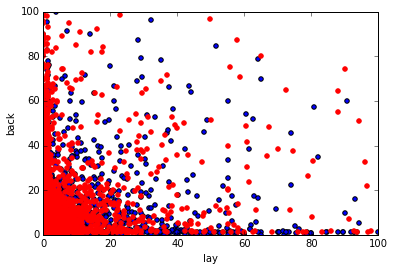

In [31]:
# average price separable? 
profit_lay_avg = profit_id_dat_by_account.apply(lambda x: x.loc[(x.BID_TYP == 'L').values, 'PRICE_TAKEN'].mean()).fillna(0)
profit_back_avg = profit_id_dat_by_account.apply(lambda x: x.loc[(x.BID_TYP == 'B').values, 'PRICE_TAKEN'].mean()).fillna(0)
non_profit_lay_avg = non_profit_id_dat_by_account.apply(lambda x: x.loc[(x.BID_TYP == 'L').values, 'PRICE_TAKEN'].mean()).fillna(0)
non_profit_back_avg = non_profit_id_dat_by_account.apply(lambda x: x.loc[(x.BID_TYP == 'B').values, 'PRICE_TAKEN'].mean()).fillna(0)
profit_price_avg = pd.concat([profit_lay_avg, profit_back_avg], axis=1)
profit_price_avg.columns = ['lay', 'back']
non_profit_price_avg = pd.concat([non_profit_lay_avg, non_profit_back_avg], axis=1)
non_profit_price_avg.columns = ['lay', 'back']
ax = profit_price_avg.plot(kind='scatter', x='lay', y='back', xlim=(0, 100), ylim=(0, 100))
non_profit_price_avg.plot(kind='scatter', x='lay', y='back', color='r', xlim=(0, 100), ylim=(0, 100), ax=ax)

In [13]:
profit_back_price = profit_id_dat.loc[(profit_id_dat.BID_TYP == 'B').values, 'PRICE_TAKEN']
non_profit_back_price = non_profit_id_dat.loc[(non_profit_id_dat.BID_TYP == 'B').values, 'PRICE_TAKEN']

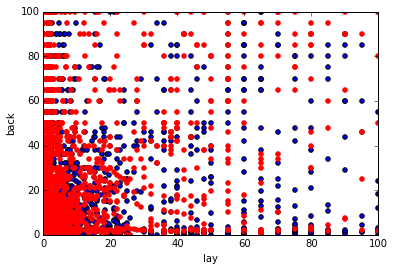

In [32]:
# max price separable? 
profit_lay_avg = profit_id_dat_by_account.apply(lambda x: x.loc[(x.BID_TYP == 'L').values, 'PRICE_TAKEN'].max()).fillna(0)
profit_back_avg = profit_id_dat_by_account.apply(lambda x: x.loc[(x.BID_TYP == 'B').values, 'PRICE_TAKEN'].max()).fillna(0)
non_profit_lay_avg = non_profit_id_dat_by_account.apply(lambda x: x.loc[(x.BID_TYP == 'L').values, 'PRICE_TAKEN'].max()).fillna(0)
non_profit_back_avg = non_profit_id_dat_by_account.apply(lambda x: x.loc[(x.BID_TYP == 'B').values, 'PRICE_TAKEN'].max()).fillna(0)
profit_price_avg = pd.concat([profit_lay_avg, profit_back_avg], axis=1)
profit_price_avg.columns = ['lay', 'back']
non_profit_price_avg = pd.concat([non_profit_lay_avg, non_profit_back_avg], axis=1)
non_profit_price_avg.columns = ['lay', 'back']
ax = profit_price_avg.plot(kind='scatter', x='lay', y='back', xlim=(0, 100), ylim=(0, 100))
non_profit_price_avg.plot(kind='scatter', x='lay', y='back', color='r', xlim=(0, 100), ylim=(0, 100), ax=ax)

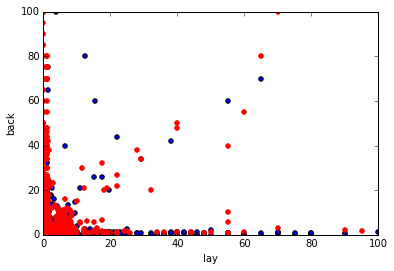

In [66]:
# max price separable? 
profit_lay_avg = profit_id_dat_by_account.apply(lambda x: x.loc[(x.BID_TYP == 'L').values, 'PRICE_TAKEN'].min()).fillna(0)
profit_back_avg = profit_id_dat_by_account.apply(lambda x: x.loc[(x.BID_TYP == 'B').values, 'PRICE_TAKEN'].min()).fillna(0)
non_profit_lay_avg = non_profit_id_dat_by_account.apply(lambda x: x.loc[(x.BID_TYP == 'L').values, 'PRICE_TAKEN'].min()).fillna(0)
non_profit_back_avg = non_profit_id_dat_by_account.apply(lambda x: x.loc[(x.BID_TYP == 'B').values, 'PRICE_TAKEN'].min()).fillna(0)
profit_price_avg = pd.concat([profit_lay_avg, profit_back_avg], axis=1)
profit_price_avg.columns = ['lay', 'back']
non_profit_price_avg = pd.concat([non_profit_lay_avg, non_profit_back_avg], axis=1)
non_profit_price_avg.columns = ['lay', 'back']


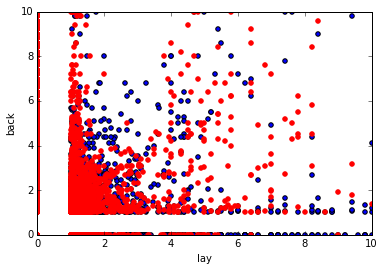

In [67]:
ax = profit_price_avg.plot(kind='scatter', x='lay', y='back', xlim=(0, 10), ylim=(0, 10))
non_profit_price_avg.plot(kind='scatter', x='lay', y='back', color='r', xlim=(0, 10), ylim=(0, 10), ax=ax)

In [10]:
profit_id_dat_by = profit_id_dat.groupby(['ACCOUNT_ID', 'EVENT_ID', 'BID_TYP', 'STATUS_ID', 'INPLAY_BET'])
non_profit_id_dat_by = non_profit_id_dat.groupby(['ACCOUNT_ID', 'EVENT_ID', 'BID_TYP', 'STATUS_ID', 'INPLAY_BET'])

In [11]:
trans_count = profit_id_dat_by.size()
trans_count.name = 'trans_count'
avg_bet_size = profit_id_dat_by['BET_SIZE'].mean()
avg_bet_size.name = 'avg_bet_size'
max_bet_size = profit_id_dat_by['BET_SIZE'].max()
max_bet_size.name = 'max_bet_size'
min_bet_size = profit_id_dat_by['BET_SIZE'].min()
min_bet_size.name = 'min_bet_size'
stdev_bet_size = profit_id_dat_by['BET_SIZE'].std()
stdev_bet_size.name = 'stdev_bet_size'
profit_loss = profit_id_dat_by['correct_profit_loss'].sum()
profit_loss.name = 'profit_res'
# put everything together
same_form_dat = pd.concat([trans_count, avg_bet_size], axis=1)
same_form_dat = pd.concat([same_form_dat, max_bet_size], axis=1)
same_form_dat = pd.concat([same_form_dat, min_bet_size], axis=1)
same_form_dat = pd.concat([same_form_dat, stdev_bet_size], axis=1)
same_form_dat = pd.concat([same_form_dat, profit_loss], axis=1)
same_form_dat = same_form_dat.fillna(0)
same_form_dat.head(20)

trans_count  avg_bet_size  \
ACCOUNT_ID EVENT_ID  BID_TYP STATUS_ID INPLAY_BET                              
1887       101092958 L       C         N                     1    197.980000   
                             S         N                     1    397.939800   
5500       101092958 L       S         N                     1     41.575800   
6229       101092958 L       C         N                     1    219.757800   
                             S         N                     3    146.505200   
12773      101092958 L       S         Y                     7     20.929314   
13123      101092958 L       C         N                    12    207.162972   
                             S         N                    21     24.665480   
13760      101092958 B       C         N                    17     12.598516   
                             S         N                     1     58.146726   
                     L       S         N                     9      9.899000   
14249      101092958 L       S         Y                     2     24.747500   
15036      101092958 L       S         Y                     1     14.947490   
20714      101092958 L       S         N                     1     39.596000   
32407      101092958 B       C         N                     7     20.080829   
                             S         Y                     1      3.959600   
                     L       C         N                     5     21.777800   
                             S         Y                     6      4.494146   
37186      101092958 L       S         Y                     1    241.535600   
38721      101092958 B       C         N                     2  22206.426700   

                                                   max_bet_size  min_bet_size  \
ACCOUNT_ID EVENT_ID  BID_TYP STATUS_ID INPLAY_BET                               
1887       101092958 L       C         N             197.980000    197.980000   
                             S         N             397.939800    397.939800   
5500       101092958 L       S         N              41.575800     41.575800   
6229       101092958 L       C         N             219.757800    219.757800   
                             S         N             219.757800      1.781820   
12773      101092958 L       S         Y              48.623888      0.871112   
13123      101092958 L       C         N             593.940000      3.959600   
                             S         N             122.747600      0.989900   
13760      101092958 B       C         N              56.939048      8.750716   
                             S         N              58.146726     58.146726   
                     L       S         N               9.899000      9.899000   
14249      101092958 L       S         Y              29.697000     19.798000   
15036      101092958 L       S         Y              14.947490     14.947490   
20714      101092958 L       S         N              39.596000     39.596000   
32407      101092958 B       C         N              57.414200      3.959600   
                             S         Y               3.959600      3.959600   
                     L       C         N              21.777800     21.777800   
                             S         Y               9.997990      0.435556   
37186      101092958 L       S         Y             241.535600    241.535600   
38721      101092958 B       C         N           33656.600000  10756.253400   

                                                   stdev_bet_size  profit_res  
ACCOUNT_ID EVENT_ID  BID_TYP STATUS_ID INPLAY_BET                              
1887       101092958 L       C         N                 0.000000    0.000000  
                             S         N                 0.000000  397.939800  
5500       101092958 L       S         N                 0.000000   41.575800  
6229       101092958 L       C         N                 0.000000    0.000000  
                           

In [127]:
same_form_dat.describe()

,trans_count,avg_bet_size,max_bet_size,min_bet_size,stdev_bet_size,profit_res
count,192291.000000,192291.000000,192291.000000,192291.000000,192291.000000,192291.000000
mean,10.219308,1464.461060,3284.521449,834.977106,766.758582,139.564162
std,68.154304,8240.264471,17853.025528,7186.292569,4574.047321,57804.228654
min,1.000000,0.010000,0.010000,0.010000,0.000000,-10051644.634829
25%,1.000000,44.236280,59.226000,9.392685,0.000000,-14.497872
50%,2.000000,206.250000,321.965751,49.512500,6.814388,0.000000
75%,6.000000,853.065630,1555.626496,262.269523,303.330383,51.831120
max,7409.000000,1963363.964520,2568409.980243,1963363.964520,567005.502914,10046827.998561


In [129]:
non_same_form_dat.describe()

,trans_count,avg_bet_size,max_bet_size,min_bet_size,stdev_bet_size,profit_res
count,227325.000000,227325.000000,227325.000000,227325.000000,227325.000000,227325.000000
mean,6.685508,1070.373094,2267.641090,650.285704,542.389717,-105.357759
std,29.138151,9378.395078,21139.792436,7595.318509,7779.420789,25710.223835
min,1.000000,0.012799,0.012799,0.006628,0.000000,-3290268.303203
25%,1.000000,38.554288,50.731582,9.889500,0.000000,-40.215659
50%,2.000000,152.403315,236.335258,48.100000,4.577855,0.000000
75%,5.000000,610.442893,1036.977920,231.432000,177.377353,11.279671
max,2498.000000,1925740.736148,6964200.000000,1925740.736148,3088540.172471,3241754.494893


In [134]:
same_form_dat.loc[([1009182],slice(None),slice(None),['S'],slice(None)),:].describe()

,trans_count,avg_bet_size,max_bet_size,min_bet_size,stdev_bet_size,profit_res
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,408.535714,3643.878445,35767.407228,6.571675,5670.007007,1414.906821
std,553.656564,1589.448702,33767.136329,13.557357,2840.006378,3259025.736613
min,14.000000,696.339354,5603.794437,0.012964,1044.480056,-10051644.634829
25%,29.750000,2248.166163,10454.533135,0.137296,3803.220028,-18252.541401
50%,80.000000,3998.530838,12421.416757,1.722908,4614.062417,5993.149626
75%,462.500000,4616.873218,64817.770684,4.211016,8096.345309,28543.214840
max,1712.000000,6837.049926,114698.362862,65.567381,11194.168453,10046827.998561


In [136]:
non_same_form_dat.loc[1002832]

trans_count    avg_bet_size  \
EVENT_ID  BID_TYP STATUS_ID INPLAY_BET                                
101093076 B       C         N                     2   115984.171958   
                  S         Y                    31     2178.912503   
          L       C         N                     1    21495.746790   
                  S         N                    95     1044.473684   
                            Y                    25     2791.650128   
101093194 B       C         N                     1    22148.964810   
                  S         Y                    11     5202.821381   
          L       C         N                     5     8213.194584   
                  S         Y                    16     4652.962886   
101150480 B       C         N                     1    22365.742310   
                  S         Y                    36     1070.301686   
          L       C         N                     1     9240.177626   
                  S         Y                    11     3651.347489   
101151090 B       C         N                     5    45819.781912   
                  S         Y                   133     1848.415639   
          L       C         N                     6    33636.399563   
                  S         Y                    76     3435.817160   
101151214 B       C         N                     1    29643.000000   
                  S         Y                    75     1317.466667   
          L       S         Y                    27     4278.107037   
101151486 L       C         N                     2      161.115764   
                  S         Y                     4       34.169118   
101151878 B       S         Y                    41     2376.829268   
101152132 B       S         Y                    96     1016.314910   
          L       S         Y                    24     5928.816667   
101152395 B       L         N                     1    16083.588232   
                  S         Y                    35     9790.846051   
          L       C         N                     1    32729.089326   
                  S         Y                   206     1743.595683   
101152576 B       S         Y                    19     8280.842105   
          L       C         N                     4   100618.756624   
                  S         Y                    53     3207.941887   
101153072 B       C         N                     1   177624.400000   
                  L         N                     1   177624.400000   
101153308 B       S         N                    38     4476.590953   
                            Y                    30     6434.000000   
          L       C         N                     7     1146.235483   
                  S         N                    18      355.643639   
                            Y                    61     3477.225556   
101153544 B       C         N                     2  1674106.627500   
                  S         Y                     7       25.701214   
          L       C         N                    10   808908.513128   
                  L         N                     1  1925740.736148   
                  S         N                    13      343.784459   
                            Y                   179     9386.256250   
101153662 B       C         N                     1    69642.000000   
          L       C         N                     5  1439988.539346   
                  S         Y                    49     3952.378529   

                                          max_bet_size    min_bet_size  \
EVENT_ID  BID_TYP STATUS_ID INPLAY_BET                                   
101093076 B       C         N            136198.060740    95770.283175   
                  S         Y             19845.000000        0.932715   
          L       C         N             21495.746790    21495.746790   
                  S         N             16752.275820        5.159700   
                            Y             257

In [138]:
same_form_dat.loc[1000002]

trans_count  avg_bet_size  \
EVENT_ID  BID_TYP STATUS_ID INPLAY_BET                              
101093076 B       S         N                     1    396.900000   
                            Y                    19    223.412921   
101093312 B       C         N                     5    146.364600   
                  S         Y                    14     69.509057   
101128387 B       C         N                     1    154.104600   
                  S         N                     1    395.140000   
                            Y                     6    164.207013   
101149398 B       C         N                     1     19.781000   
                  S         Y                     5     79.124000   
101149516 B       C         N                     1     49.082500   
                  S         N                     3    219.235167   
                            Y                     8    175.825786   
101149634 B       C         N                     2    169.782200   
                  S         N                     1    785.120000   
                            Y                    11    111.843913   
101150348 B       S         N                     1    393.880000   
                            Y                     1    196.940000   
101150480 B       C         N                     2    178.826338   
                  S         Y                    14     43.921045   
101150598 B       C         N                     1     17.785800   
                  S         N                     3    131.746667   
                            Y                    11    106.046485   
101150716 B       C         N                     2     93.841000   
                  S         N                     3    263.413333   
                            Y                    14    155.634946   
101150834 B       C         N                     7    129.592129   
                  S         Y                    35    127.366359   
101151090 B       C         N                     4     76.577750   
                  S         Y                    21     82.994754   
101151214 B       C         N                     3    174.386475   
                  S         N                     2    197.620000   
                            Y                    29    151.572496   
101151878 B       C         N                     3     29.884667   
                  S         N                     1    389.800000   
                            Y                     7     76.846286   
101152014 B       C         N                     5    131.555406   
                  L         N                     1      9.746000   
                  S         Y                    15    219.999707   
101152132 B       C         N                     8     80.065827   
                  S         Y                    29     88.486959   
101152395 B       S         Y                     5     85.401240   
101152576 B       S         Y                     2     88.501500   
101152715 B       C         N                     2     26.659800   
                  S         Y                    12    193.999415   
101152836 B       C         N                     1     12.494856   
                  S         Y                     3    397.084952   
101153072 B       C         N                     2    187.277900   
                  S         Y                    10     44.931250   
101153662 B       S         Y                    10    154.566550   
101183237 B       C         N                     1    964.300000   
                  S         N                     4    387.518419   
                            Y                    10    231.676932   
101183757 B       C         N                     3     37.777040   
                  S         N                     1    192.740000   
                            Y                     6     95.149313   
101183885 B       C         N                     2     23.224800   
                  S         Y         

In [12]:
non_trans_count = non_profit_id_dat_by.size()
non_trans_count.name = 'trans_count'
non_avg_bet_size = non_profit_id_dat_by['BET_SIZE'].mean()
non_avg_bet_size.name = 'avg_bet_size'
non_max_bet_size = non_profit_id_dat_by['BET_SIZE'].max()
non_max_bet_size.name = 'max_bet_size'
non_min_bet_size = non_profit_id_dat_by['BET_SIZE'].min()
non_min_bet_size.name = 'min_bet_size'
non_stdev_bet_size = non_profit_id_dat_by['BET_SIZE'].std()
non_stdev_bet_size.name = 'stdev_bet_size'
non_profit_loss = non_profit_id_dat_by['correct_profit_loss'].sum()
non_profit_loss.name = 'profit_res'
# put everything together
non_same_form_dat = pd.concat([non_trans_count, non_avg_bet_size], axis=1)
non_same_form_dat = pd.concat([non_same_form_dat, non_max_bet_size], axis=1)
non_same_form_dat = pd.concat([non_same_form_dat, non_min_bet_size], axis=1)
non_same_form_dat = pd.concat([non_same_form_dat, non_stdev_bet_size], axis=1)
non_same_form_dat = pd.concat([non_same_form_dat, non_profit_loss], axis=1)
non_same_form_dat = non_same_form_dat.fillna(0)
non_same_form_dat.head(20)

trans_count  avg_bet_size  \
ACCOUNT_ID EVENT_ID  BID_TYP STATUS_ID INPLAY_BET                              
682        101092958 B       C         N                     4   2192.628500   
1011       101092958 B       C         N                     1     49.495000   
                             S         Y                     1     49.495000   
1534       101092958 B       C         N                     1      5.939400   
                             S         Y                     2      3.464650   
                     L       C         N                     1   2036.838038   
2155       101092958 B       S         Y                     2     24.747500   
2166       101092958 B       C         N                     3     31.676800   
                             S         Y                     2     45.535400   
                     L       L         N                     1      3.959600   
                             S         Y                     1     87.111200   
2627       101092958 B       S         Y                     1     49.495000   
2784       101092958 L       S         N                     2    247.475000   
3614       101092958 B       C         N                     1      7.919200   
3773       101092958 L       S         Y                     1   1668.971400   
3877       101092958 L       S         Y                     1     39.596000   
4703       101092958 L       C         N                     1    156.404200   
4961       101092958 B       S         N                     1     39.596000   
5281       101092958 B       C         N                     3   5609.433333   
                     L       C         N                     1   9899.000000   

                                                   max_bet_size  min_bet_size  \
ACCOUNT_ID EVENT_ID  BID_TYP STATUS_ID INPLAY_BET                               
682        101092958 B       C         N            3425.054000    593.940000   
1011       101092958 B       C         N              49.495000     49.495000   
                             S         Y              49.495000     49.495000   
1534       101092958 B       C         N               5.939400      5.939400   
                             S         Y               5.187076      1.742224   
                     L       C         N            2036.838038   2036.838038   
2155       101092958 B       S         Y              43.555600      5.939400   
2166       101092958 B       C         N              87.111200      3.959600   
                             S         Y              87.111200      3.959600   
                     L       L         N               3.959600      3.959600   
                             S         Y              87.111200     87.111200   
2627       101092958 B       S         Y              49.495000     49.495000   
2784       101092958 L       S         N             331.200742    163.749258   
3614       101092958 B       C         N               7.919200      7.919200   
3773       101092958 L       S         Y            1668.971400   1668.971400   
3877       101092958 L       S         Y              39.596000     39.596000   
4703       101092958 L       C         N             156.404200    156.404200   
4961       101092958 B       S         N              39.596000     39.596000   
5281       101092958 B       C         N            7919.200000   2969.700000   
                     L       C         N            9899.000000   9899.000000   

                                                   stdev_bet_size  profit_res  
ACCOUNT_ID EVENT_ID  BID_TYP STATUS_ID INPLAY_BET                              
682        101092958 B       C         N              1341.147071     0.00000  
1011       101092958 B       C         N                 0.000000     0.00000  
                             S         Y                 0.000000   -49.49500  
1534       101092958 B       C         N                 0.000000     0.00000  
                           

In [28]:
submit = pd.read_csv('sample_submission_bet_size.csv')
submit.columns = ['ACCOUNT_ID', 'Prediction']

In [29]:
submit.head()

,ACCOUNT_ID,Prediction
0,1004240,19027.790500
1,1009742,530423.584971
2,1003908,2264.014397
3,1020888,657.100800
4,1010074,2709.854433


In [132]:
submit.loc[(submit.ACCOUNT_ID == 1002832).values]

,ACCOUNT_ID,Prediction


In [31]:
finals = pd.read_csv('semi_and_final_features.csv')
finals.columns = ['ACCOUNT_ID', 'EVENT_ID', 'TRANSACTION_COUNT', 'STATUS_ID',
       'INPLAY_BET', 'AVG_BET_SIZE', 'MAX_BET_SIZE', 'MIN_BET_SIZE',
       'STDEV_BET_SIZE']

In [69]:
rfc = RandomForestRegressor()
scores = cross_val_score(rfc, 
                         same_form_dat.loc[([1009182], slice(None), slice(None), ['S'], slice(None)), ['trans_count', 'avg_bet_size',
                                                                                     'max_bet_size', 'min_bet_size',
                                                                                     'stdev_bet_size']],
                         same_form_dat.loc[([1009182], slice(None), slice(None), ['S'], slice(None)), 'profit_res'],
                         cv=4,
                         scoring='mean_absolute_error')
scores

array([-2468802.50010082, -3563919.4490161 ,  -336260.30684282,
         -17441.04117037])

In [14]:
scores

array([-3441.77997118, -7116.84573922, -4717.52136467, -2487.05578867])

In [71]:
rfc = RandomForestRegressor()
scores = cross_val_score(rfc, 
                         non_same_form_dat.loc[([1002832], slice(None), slice(None), ['S'], slice(None)), ['trans_count', 'avg_bet_size',
                                                                                     'max_bet_size', 'min_bet_size',
                                                                                     'stdev_bet_size']],
                         non_same_form_dat.loc[([1002832], slice(None), slice(None), ['S'], slice(None)), 'profit_res'],
                         cv=4,
                         scoring='mean_absolute_error')
scores

array([-29571.39210463, -97678.04017467, -88675.86066325, -66846.82861653])

In [27]:
dat = pd.concat([same_form_dat, non_same_form_dat])
dat = dat.sort_index().loc[(slice(None), slice(None), slice(None), ['S'], slice(None)), :]
rfc = RandomForestRegressor()
rfc.fit(dat[['trans_count', 'avg_bet_size', 'max_bet_size', 'min_bet_size', 'stdev_bet_size']], dat['profit_res'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [38]:
for_submit = finals.loc[((finals.ACCOUNT_ID.isin(submit.ACCOUNT_ID)) & (finals.STATUS_ID == 'S')).values,
                        ['ACCOUNT_ID', 'TRANSACTION_COUNT', 'AVG_BET_SIZE', 'MAX_BET_SIZE', 'MIN_BET_SIZE', 'STDEV_BET_SIZE']]

In [39]:
pred = rfc.predict(for_submit[['TRANSACTION_COUNT', 'AVG_BET_SIZE', 'MAX_BET_SIZE', 'MIN_BET_SIZE', 'STDEV_BET_SIZE']])

In [40]:
pred

array([  -158.06655271,   -961.32760306,  -2005.88220571, ...,
        63887.16487839, -19776.91120512,  19603.60884171])

In [42]:
rfg_pred = pd.DataFrame({'Account_ID': for_submit.ACCOUNT_ID, 'Prediction': pred})

In [44]:
rfg_pred_by_Acc = rfg_pred.groupby('Account_ID')
rfg_pred_res = rfg_pred_by_Acc['Prediction'].sum()

In [47]:
rfg_pred_res = rfg_pred_res.reset_index()

In [49]:
rfg_pred_res.to_csv('rfg.csv', index=False)

In [51]:
rfg_pred_res.head()

,Account_ID,Prediction
0,1000002,-2944.983560
1,1000004,52.808448
2,1000005,10.598393
3,1000010,49.675104
4,1000014,-178.096936


In [53]:
br = BayesianRidge()
br.fit(dat[['trans_count', 'avg_bet_size', 'max_bet_size', 'min_bet_size', 'stdev_bet_size']], dat['profit_res'])

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)

In [54]:
pred = br.predict(for_submit[['TRANSACTION_COUNT', 'AVG_BET_SIZE', 'MAX_BET_SIZE', 'MIN_BET_SIZE', 'STDEV_BET_SIZE']])

In [55]:
br_pred = pd.DataFrame({'Account_ID': for_submit.ACCOUNT_ID, 'Prediction': pred})

In [56]:
br_pred_by_Acc = br_pred.groupby('Account_ID')
br_pred_res = br_pred_by_Acc['Prediction'].sum()

In [57]:
br_pred_res = br_pred_res.reset_index()

In [58]:
br_pred_res.head()

,Account_ID,Prediction
0,1000002,102.453264
1,1000004,32.042067
2,1000005,83.921659
3,1000010,92.468409
4,1000014,68.352103


In [59]:
br_pred_res.to_csv('br.csv', index=False)

In [75]:
br = BayesianRidge(n_iter=5000)
scores = cross_val_score(br, 
                         same_form_dat.loc[([1009182], slice(None), slice(None), ['S'], slice(None)), ['trans_count', 'avg_bet_size',
                                                                                     'max_bet_size', 'min_bet_size',
                                                                                     'stdev_bet_size']],
                         same_form_dat.loc[([1009182], slice(None), slice(None), ['S'], slice(None)), 'profit_res'],
                         cv=3,
                         scoring='mean_absolute_error')
scores

array([-3688288.71529689,  -130320.66317324,   -17317.69558298])

In [76]:
br = BayesianRidge()
scores = cross_val_score(br, 
                         non_same_form_dat.loc[([1002832], slice(None), slice(None), ['S'], slice(None)), ['trans_count', 'avg_bet_size',
                                                                                     'max_bet_size', 'min_bet_size',
                                                                                     'stdev_bet_size']],
                         non_same_form_dat.loc[([1002832], slice(None), slice(None), ['S'], slice(None)), 'profit_res'],
                         cv=3,
                         scoring='mean_absolute_error')
scores

array([-77002.38276898, -77394.74957689, -50293.70909636])

In [77]:
non_same_form_dat.loc[([1002832], slice(None), slice(None), ['S'], slice(None)), 'profit_res'].describe()

count        27.000000
mean      -4694.913667
std      100467.732434
min     -245839.280000
25%      -53261.020610
50%        -179.908500
75%       19450.211671
max      261122.104128
Name: profit_res, dtype: float64